# Bug in Lake Salton

Lake Salton was at a historic water level low. This caused the JRC water filling to fail.
In this notebook, this shortcoming is fixed using:

- JRC extrapolation
- mosaicking images by mission and day
- filtering images by overlap with the waterbody

In [1]:
!pip uninstall -y eepackages

In [2]:
import os
from pathlib import Path
import sys

import ee


# Import debug version of eepackages, otherwise install latest
sys.path.append(str(Path.cwd().parent.parent.parent.parent.absolute()) + os.sep + "ee-packages-py")

from eepackages.applications.waterbody_area import computeSurfaceWaterArea, extrapolate_JRC_wo

In [3]:
ee.Initialize()

First we run the full algorithm to see where we have strange data points:

In [4]:
# fid = 77130  # Taiwan
# fid = 83161  # some lake in germany
# fid = 89683  # Maggiore
# fid = 92107  # Tana
fid = 90686 # Salton
# fid = 90554  # Mead
# fid = 92429  # Volta
waterbody = ee.Feature(ee.FeatureCollection("projects/global-water-watch/assets/reservoirs/quality_score_reservoirs").filter(ee.Filter.eq("fid", fid)).first())
export_time_start_filter = "2021-01-01"
export_time_start = "2022-01-01"
export_time_stop = "2023-04-01"
water_occurrence = (
    ee.Image("JRC/GSW1_3/GlobalSurfaceWater")
    .select("occurrence")
    .unmask(0)
    .resample("bicubic")
    .divide(100)
)

In [5]:
scale = ee.Feature(waterbody).geometry().area().sqrt().divide(200).max(10).getInfo()

# Extrapolate water Occurrence
water_occurrence = extrapolate_JRC_wo(waterbody, scale, 0.97)

missions = ["L4", "L5", "L7", "L8", "L9", "S2"]

water_area = computeSurfaceWaterArea(
    waterbody=ee.Feature(waterbody),
    start_filter=export_time_start_filter,
    start=export_time_start,
    stop=export_time_stop,
    scale=scale,
    mosaic_by_day=True,
    waterOccurrence=ee.Image(water_occurrence),
    opt_missions=missions,
    quality_score_attributes=["qTh_0"],  # ["qTh_15", "qTh_10", "qTh_5", "qTh_0"],
    min_overlap_fraction=0.4
)

water_area = (
    ee.FeatureCollection(water_area)
    .filter(
        ee.Filter.And(
            ee.Filter.neq("p", 101),
            ee.Filter.gt("ndwi_threshold", -0.15),
            ee.Filter.lt("ndwi_threshold", 0.5),
            ee.Filter.lt("filled_fraction", 0.6),
        )
    )
    .sort("system:time_start")
)

properties = [
    "MISSION",
    "ndwi_threshold",
    "quality_score",
    "area_filled",
    "filled_fraction",
    "p",
    "system:time_start",
    "area",
]
properties_new = [
    "mission",
    "ndwi_threshold",
    "quality_score",
    "water_area_filled",
    "water_area_filled_fraction",
    "water_area_p",
    "water_area_time",
    "water_area_value",
]

water_area = (
    ee.FeatureCollection(water_area)
    .select(properties, properties_new, False)
    .set("scale", scale)
)

In [6]:
scale

159.3099122465834

In [7]:
water_area = water_area.getInfo()

In [8]:
import pandas as pd
df: pd.DataFrame = pd.DataFrame(
    list(map(lambda feature: feature["properties"], water_area["features"]))
)

In [9]:
df["water_area_time"] = pd.to_datetime(df["water_area_time"], unit="ms", utc=True)

In [10]:
df

,mission,ndwi_threshold,quality_score,water_area_filled,water_area_filled_fraction,water_area_p,water_area_time,water_area_value
0,S2,0.320997,0.087600,8.363519e+08,0.003315,0.970230,2022-01-05 00:00:00+00:00,8.335790e+08
1,L9,0.256685,0.094660,8.380376e+08,0.003762,0.970244,2022-01-08 00:00:00+00:00,8.348850e+08
2,S2,0.305335,0.076450,8.440675e+08,0.012458,0.960000,2022-01-20 00:00:00+00:00,8.335524e+08
3,S2,0.306042,0.077450,8.442477e+08,0.012105,0.960000,2022-01-30 00:00:00+00:00,8.340284e+08
4,S2,0.257238,0.086400,8.384963e+08,0.002245,0.970196,2022-02-04 00:00:00+00:00,8.366142e+08
...,...,...,...,...,...,...,...,...
74,S2,0.226831,0.118467,8.191553e+08,0.488479,0.970525,2023-02-14 00:00:00+00:00,4.190147e+08
75,S2,0.288572,0.097600,8.290427e+08,0.003321,0.970341,2023-02-19 00:00:00+00:00,8.262895e+08
76,S2,0.306401,0.089600,8.308038e+08,0.488699,0.970245,2023-02-24 00:00:00+00:00,4.247909e+08
77,S2,0.273809,0.087600,8.290251e+08,0.001737,0.970304,2023-03-26 00:00:00+00:00,8.275854e+08


<Axes: xlabel='water_area_time'>

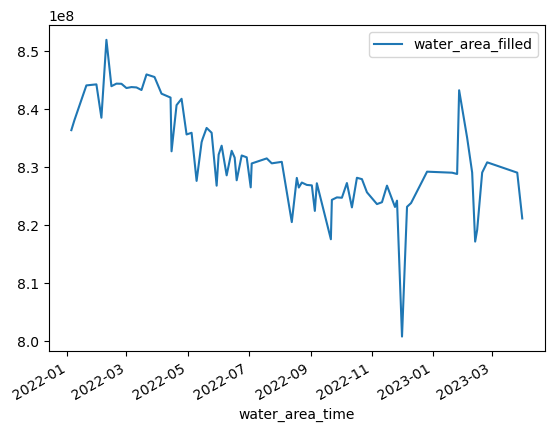

In [14]:
df.plot("water_area_time", "water_area_filled")

## Get Images
Obtain raw images

In [15]:
from datetime import datetime

from eepackages.assets import getImages, getMostlyCleanImages, mosaic_by_day
from eepackages.utils import computeThresholdUsingOtsu
import geemap

In [16]:
images = getImages(waterbody.geometry(), {
    'resample': True,
    'filter': ee.Filter.date(export_time_start, export_time_stop),
    'missions': missions,
    'scale': scale * 10,
}).sort("system:time_start")

In [17]:
images.size()

### Get Mostly Clean Images
Get mostly clean images based on quality score of green pixel

In [18]:
quality_score_attributes = ["qTh_0"] #  ["qTh_15", "qTh_10", "qTh_5", "qTh_0"]
props = waterbody.getInfo()["properties"]
quality_score_threshold = None
if quality_score_attributes:
    for prop in quality_score_attributes:
        att = props.get(prop)
        if att:
            quality_score_threshold = att
            break

options = {
  # 'cloudFrequencyThresholdDelta': -0.15
   'scale': scale * 5,
   'cloud_frequency': props.get('cloud_frequency'),
   'quality_score_cloud_threshold': quality_score_threshold,
}

g = waterbody.geometry().buffer(300, scale)

images = getMostlyCleanImages(images, g, options).sort('system:time_start')

In [19]:
images.size()

## Merge ImageCollection

In [20]:
mosaicked = mosaic_by_day(images)

In [21]:
mosaicked.size()

In [22]:
start_date = ee.Date("2022-11-01")
check = images.filterDate(start_date, start_date.advance(1, "day"))

In [23]:
check_list = check.toList(check.size())

In [24]:
Map = geemap.Map()
for i in range(check.size().getInfo()):
    Map.addLayer(ee.Image(check_list.get(i)), {"bands": ["red", "green", "blue"], "min": 0, "max": 0.3}, f"mosaic_{i}")
Map.centerObject(waterbody)

In [25]:
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [26]:
mosaicked_image = ee.Image(mosaicked.filter(ee.Filter.date("2022-11-01")).first())
# print(datetime.utcfromtimestamp(mosaicked_image.get("system:time_start").getInfo() / 1000))
# print(mosaicked_image.get("MISSION").getInfo())

In [27]:
mosaicked_image.get("quality_score").getInfo()

0.11651878212340779

In [28]:
Map = geemap.Map()
Map.addLayer(mosaicked_image, {"bands": ["red", "green", "blue"], "min": 0, "max": 0.3}, "mosaic")
Map.centerObject(waterbody)

In [29]:
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

### Check if footprint image is above threshold

In [30]:
print(f"area image over waterbody: {ee.Geometry(mosaicked_image.get('system:footprint')).intersection(waterbody.geometry()).area().getInfo()}")
print(f"waterbody_area: {waterbody.get('area').getInfo()}")

area image over waterbody: 359090458.23663557
waterbody_area: 1014742297.2162995


Then filter based on iamge footprint ratio

In [31]:
wgeom = waterbody.geometry()
def set_intersection(i):
    intersection_area = ee.Geometry(i.get('system:footprint')).intersection(wgeom).area()
    waterbody_area = waterbody.get('area')
    i = i.set("overlap_fraction", intersection_area.divide(waterbody_area))
    return i

In [32]:
mosaicked_i = mosaicked.map(set_intersection)
mosaicked_f = mosaicked_i.filter(ee.Filter.gt("overlap_fraction", 0.4))

In [33]:
mosaicked_f.size()

## Test steps water area algorithm

An individual image with an incorrect water area value is taken. Then we plot different steps in the algorithm to debug what is happening at each step.

First we can the correct image and call it `i`

In [34]:
# i = image
i = ee.Image(mosaicked_image)

In [35]:
datetime.utcfromtimestamp(i.get('system:time_start').getInfo() * 1e-3)

datetime.datetime(2022, 11, 1, 0, 0)

Then we execute the `get_water_area_singleImage` function step by step

In [36]:
fillPercentile = 50 # // we don't trust our prior
ndwiBands = ['green', 'swir']
waterMaxImage = ee.Image().float().paint(waterbody.buffer(150), 1)
t = i.get('system:time_start')
i = (i
    .updateMask(waterMaxImage)
    .updateMask(i.select('swir').min(i.select('nir')).gt(0.001)))

In [37]:
geom = ee.Feature(waterbody).geometry()
ndwi = i.normalizedDifference(ndwiBands)
th = computeThresholdUsingOtsu(ndwi, scale, geom, 0.5, 0.7, -0.2)
water = ndwi.gt(th)

print threshold value

In [38]:
th.getInfo()

0.35217690275522817

Function to extrapolate the JRC to from a maximum "trusted" water occurrence value to 1.0 to the center of the waterbody

In [39]:
def extrapolate_JRC(waterbody, scale, max_trusted_occurrence=0.97):
    water_occurrence = (
        ee.Image("JRC/GSW1_4/GlobalSurfaceWater")
        .select("occurrence")
        .mask(1)  # fixes JRC masking lacking
        .resample("bicubic")
        .divide(100)
    )

    # we don't trust water occurrence dataset when water level is below this (values > th)
    min_water = water_occurrence.gt(max_trusted_occurrence)

    # Calculate distance from water Occurence max
    dist = (
        min_water.Not()
        .fastDistanceTransform(150)
        .reproject(ee.Projection("EPSG:4326").atScale(100))
        .resample("bicubic")
        .sqrt()
        .multiply(100)
    )

    # calculate max distance for scaling to 1
    max_distance = dist.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=waterbody.geometry(),
        scale=scale,
        bestEffort=True,
    ).get("distance")

    # scale distance values from min_trusted_occurrence to 1
    extrap_scale = ee.Number(1).subtract(max_trusted_occurrence).divide(max_distance)
    water_occurrence_extrapolated = dist.multiply(extrap_scale).add(
        max_trusted_occurrence
    )

    return water_occurrence.where(
        water_occurrence.gt(max_trusted_occurrence), water_occurrence_extrapolated
    )

### Set different water occurrence for gap filling
Set what should be used as reference water occurrence

In [40]:
# waterOccurrence = water_occurrence
# waterOccurrence = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').select('water').mean()
waterOccurrence = extrapolate_JRC(waterbody, scale, max_trusted_occurrence=0.97).unmask(0)

Then run the rest of the algorithm

In [41]:
area = (ee.Image.pixelArea().mask(water)
.reduceRegion(**{
  'reducer': ee.Reducer.sum(),
  'geometry': geom,
  'scale': scale
}).get('area'))

waterEdge = ee.Algorithms.CannyEdgeDetector(ndwi, 0.5, 0.7)
imageMask = ndwi.mask()

imageMask = imageMask.focal_min(ee.Number(scale).multiply(1.5), 'square', 'meters')
waterEdge = waterEdge.updateMask(imageMask)

p = waterOccurrence.mask(waterEdge).reduceRegion(**{
'reducer': ee.Reducer.percentile([fillPercentile]),
'geometry': geom,
'scale': scale
}).values().get(0)

In [42]:
print(p.getInfo())

0.9804109491846686


Check out if the 95th percentile value is the same as p, often an indication that we are using JRC's "maximum" p

In [43]:
p95 = waterOccurrence.mask(waterEdge).reduceRegion(**{
'reducer': ee.Reducer.percentile([95]),
'geometry': geom,
'scale': scale
}).values().get(0)

In [44]:
print(p95.getInfo())

0.987074906784808


The JRC has a maximum p value often higher than 1.0, probably due to resampling?

In [45]:
pMax = waterOccurrence.mask(waterEdge).reduceRegion(**{
'reducer': ee.Reducer.max(),
'geometry': geom,
'scale': scale
}).values().get(0)

In [46]:
print(pMax.getInfo())

0.9904483196432943


In [47]:
p = ee.Algorithms.If(ee.Algorithms.IsEqual(p, None), 101, p)

waterFill = waterOccurrence.gte(ee.Image.constant(p)).updateMask(  # TODO
    water.unmask(0, False).Not()
)
nonWater = ndwi.lt(-0.15).unmask(0, False)
waterFill = waterFill.updateMask(nonWater.Not())

## Plot Debug Layers

To investigate each step of the algorithm, lots of debugging layers are printed together with the water area observed and the water area filled

In [48]:
Map = geemap.Map()
Map.addLayer(i, {"bands": ["red", "green", "blue"]}, "raw")
Map.addLayer(waterFill, {}, "waterFill")
Map.addLayer(waterOccurrence, {}, "water occurrence used for water fill")
Map.addLayer(water, {}, "water detected")
Map.addLayer(nonWater, {}, "very low NDWI levels")
Map.addLayer(waterEdge, {"palette": ["red", "blue"]}, "edge detected")
Map.centerObject(waterbody)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [49]:
fill = (
        ee.Image.pixelArea()
        .mask(waterFill)
        .reduceRegion(**{"reducer": ee.Reducer.sum(), "geometry": geom, "scale": scale})
        .get("area")
    )

In [50]:
print(f"fill is {fill.getInfo() / 1e6} km2")
print(f"area is {area.getInfo() / 1e6} km2")

fill is 281.6291777734375 km2
area is 212.33225303830423 km2
